## SQL analysis of Olist e-commerce data with PostgreSQL
This e-commerce data analysis project is based on the “Brazilian E-Commerce Public Dataset by Olist” available on Kaggle. From several CSV files representing orders, customers, sellers, payments, deliveries and products, we built a relational database in PostgreSQL. Using Python, psycopg2, pandas, and Jupyter Notebook, advanced SQL queries explored sales performance, purchasing behavior, delivery times and customer ratings. This project showcases strong skills in data modeling, SQL manipulation, and analysis via a Python environment connected to a PostgreSQL database.

### Installing and importing the necessary libraries

In [ ]:
pip install psycopg2-binary pandas jupyter notebook matplotlib seaborn          

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user ipython-sql

Note: you may need to restart the kernel to use updated packages.


In [57]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from psycopg2.extras import execute_values

### olist_e_commerce database connection from PostgreSql

In [14]:
# Connexion
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    database="olist_e_commerce",
    user="postgres",
    password=2580
)

print("Connection established")

Connection established


### Table creation

In [15]:
cursor = conn.cursor()

create_table_query = """
-- Table : customers
CREATE TABLE IF NOT EXISTS customers (
    customer_id VARCHAR PRIMARY KEY,
    customer_unique_id VARCHAR,
    customer_zip_code_prefix INTEGER,
    customer_city VARCHAR,
    customer_state VARCHAR
);

-- Table : orders
CREATE TABLE IF NOT EXISTS orders (
    order_id VARCHAR PRIMARY KEY,
    customer_id VARCHAR REFERENCES customers(customer_id),
    order_status VARCHAR,
    order_purchase_timestamp TIMESTAMP,
    order_approved_at TIMESTAMP,
    order_delivered_carrier_date TIMESTAMP,
    order_delivered_customer_date TIMESTAMP,
    order_estimated_delivery_date TIMESTAMP
);

-- Table : sellers
CREATE TABLE IF NOT EXISTS sellers (
    seller_id VARCHAR PRIMARY KEY,
    seller_zip_code_prefix INTEGER,
    seller_city VARCHAR,
    seller_state VARCHAR
);

-- Table : products
CREATE TABLE IF NOT EXISTS products (
    product_id VARCHAR PRIMARY KEY,
    product_category_name VARCHAR,
    product_name_lenght INTEGER,
    product_description_lenght INTEGER,
    product_photos_qty INTEGER,
    product_weight_g INTEGER,
    product_length_cm INTEGER,
    product_height_cm INTEGER,
    product_width_cm INTEGER
);

-- Table : order_items
CREATE TABLE IF NOT EXISTS order_items (
    order_id VARCHAR REFERENCES orders(order_id),
    order_item_id INTEGER,
    product_id VARCHAR REFERENCES products(product_id),
    seller_id VARCHAR REFERENCES sellers(seller_id),
    shipping_limit_date TIMESTAMP,
    price NUMERIC,
    freight_value NUMERIC,
    PRIMARY KEY(order_id, order_item_id)
);

-- Table : reviews
CREATE TABLE IF NOT EXISTS reviews (
    order_id VARCHAR REFERENCES orders(order_id),
    review_id VARCHAR,
    review_score NUMERIC,
    review_comment_title VARCHAR,
    review_comment_message VARCHAR,
    review_creation_date TIMESTAMP,
    review_answer_timestamp TIMESTAMP,
    PRIMARY KEY(order_id, review_id)
);

-- Table : payments
CREATE TABLE IF NOT EXISTS payments (
    order_id VARCHAR REFERENCES orders(order_id),
    payment_sequential NUMERIC,
    payment_type VARCHAR,
    payment_installments NUMERIC,
    payment_value NUMERIC,
    PRIMARY KEY(order_id)
);

-- Table : geolocation
CREATE TABLE IF NOT EXISTS geolocation (
    geolocation_zip_code_prefix VARCHAR,
    geolocation_lat DOUBLE PRECISION,
    geolocation_lng DOUBLE PRECISION,
    geolocation_city VARCHAR,
    geolocation_state VARCHAR
);
"""

cursor.execute(create_table_query)
conn.commit()
print("✅ Tables created.")

✅ Tables created.


### Loaded the contents of the CSV files downloaded from Kaagle into the corresponding tables in the PostgreSQL database

In [16]:
def preprocess_dataframe(df):
    
    # Automatically convert date-like columns to datetime and replace NaN with None for PostgreSQL insertion.
    
    for col in df.columns:
        if 'date' in col or 'timestamp' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')  # convert to datetime (NaT if invalid)

    df = df.astype(object)  # allow mixed types (str, None, datetime)
    df = df.where(pd.notnull(df), None)  # replace both NaN and NaT with None

    return df

def insert_data(df, table_name):
    
    # Generic function to insert a pandas DataFrame into a PostgreSQL table.
    
    df = preprocess_dataframe(df)  # preprocessing before insertion
    cols = list(df.columns)
    query = f"INSERT INTO {table_name} ({', '.join(cols)}) VALUES %s ON CONFLICT DO NOTHING;"
    values = [tuple(x) for x in df.to_numpy()]
    execute_values(cursor, query, values)
    conn.commit()
    print(f"{len(values)} rows inserted into table {table_name}")

# --- Load and insert datasets ---

# customers
df_customers = pd.read_csv('dataset/olist_customers_dataset.csv')
insert_data(df_customers, 'customers')

# orders
df_orders = pd.read_csv('dataset/olist_orders_dataset.csv')
insert_data(df_orders, 'orders')

# sellers
df_sellers = pd.read_csv('dataset/olist_sellers_dataset.csv')
insert_data(df_sellers, 'sellers')

# products
df_products = pd.read_csv('dataset/olist_products_dataset.csv')
insert_data(df_products, 'products')

# order_items
df_order_items = pd.read_csv('dataset/olist_order_items_dataset.csv')
insert_data(df_order_items, 'order_items')

# reviews
df_order_items = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
insert_data(df_order_items, 'reviews')

# payments
df_order_items = pd.read_csv('dataset/olist_order_payments_dataset.csv')
insert_data(df_order_items, 'payments')

# geolocation
df_order_items = pd.read_csv('dataset/olist_geolocation_dataset.csv')
insert_data(df_order_items, 'geolocation')

99441 rows inserted into table customers
99441 rows inserted into table orders
3095 rows inserted into table sellers
32951 rows inserted into table products
112650 rows inserted into table order_items
99224 rows inserted into table reviews
103886 rows inserted into table payments
1000163 rows inserted into table geolocation


### Exploratory analysis

#### Geolocation 

In [26]:
# Count of unique zip code prefixes
query = "SELECT COUNT(DISTINCT geolocation_zip_code_prefix) AS unique_zip_codes FROM geolocation;"
df_geo = pd.read_sql(query, conn)
df_geo

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\1639111697.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_geo = pd.read_sql(query, conn)


,unique_zip_codes
0,19015


In [27]:
# Top 10 cities with most geolocation entries
query = "SELECT geolocation_city, COUNT(*) AS count FROM geolocation GROUP BY geolocation_city ORDER BY count DESC LIMIT 10;"
df_geo = pd.read_sql(query, conn)
df_geo

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3680781135.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_geo = pd.read_sql(query, conn)


,geolocation_city,count
0,sao paulo,135800
1,rio de janeiro,62151
2,belo horizonte,27805
3,são paulo,24918
4,curitiba,16593
5,porto alegre,13521
6,salvador,11865
7,guarulhos,11340
8,brasilia,10470
9,sao bernardo do campo,8112


In [28]:
# Check for missing or invalid coordinates
query = """
SELECT COUNT(*) AS invalid_coords
FROM geolocation
WHERE geolocation_lat IS NULL OR geolocation_lng IS NULL;
"""
df_geo = pd.read_sql(query, conn)
df_geo

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2055447027.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_geo = pd.read_sql(query, conn)


,invalid_coords
0,0


#### Payments

In [65]:
# Distribution of payment types
query = """
SELECT payment_type, COUNT(*) AS total FROM payments GROUP BY payment_type;
"""
df_pay = pd.read_sql(query, conn)
df_pay

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2385216564.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pay = pd.read_sql(query, conn)


,payment_type,total
0,not_defined,3
1,boleto,19784
2,debit_card,1527
3,voucher,2739
4,credit_card,75387


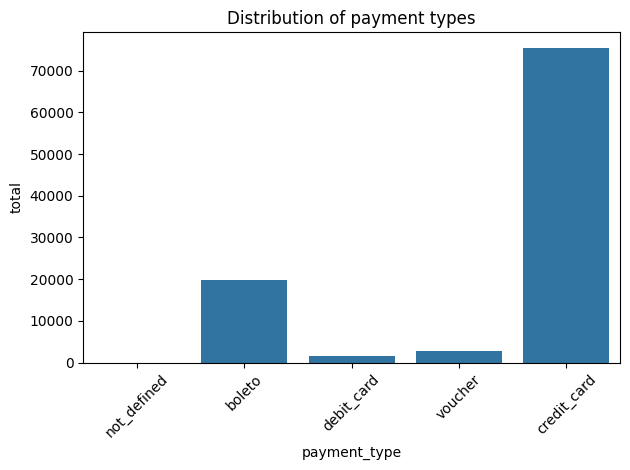

In [66]:
sns.barplot(x='payment_type', y='total', data=df_pay)
plt.title('Distribution of payment types')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

In [32]:
# Average payment value per type
query = """
SELECT payment_type, ROUND(AVG(payment_value), 2) AS avg_value FROM payments GROUP BY payment_type;
"""
df_pay = pd.read_sql(query, conn)
df_pay

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\1002215279.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pay = pd.read_sql(query, conn)


,payment_type,avg_value
0,not_defined,0.00
1,boleto,145.03
2,debit_card,142.71
3,voucher,87.17
4,credit_card,164.73


In [33]:
# Number of installments distribution
query = """
SELECT payment_installments, COUNT(*) AS count FROM payments GROUP BY payment_installments ORDER BY count DESC;
"""
df_pay = pd.read_sql(query, conn)
df_pay

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3129932849.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pay = pd.read_sql(query, conn)


,payment_installments,count
0,1.0,48664
1,2.0,12250
2,3.0,10349
3,4.0,7028
4,10.0,5261
5,5.0,5193
6,8.0,4229
7,6.0,3879
8,7.0,1608
9,9.0,639


#### reviews

In [34]:
# Review score distribution
query = """
SELECT review_score, COUNT(*) AS count FROM reviews GROUP BY review_score ORDER BY review_score;
"""
df_reviews = pd.read_sql(query, conn)
df_reviews

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2792893865.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_reviews = pd.read_sql(query, conn)


,review_score,count
0,1.0,11424
1,2.0,3151
2,3.0,8179
3,4.0,19142
4,5.0,57328


In [35]:
# Average review score
query = """
SELECT ROUND(AVG(review_score), 2) AS avg_score FROM reviews;
"""
df_reviews = pd.read_sql(query, conn)
df_reviews

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\1568264659.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_reviews = pd.read_sql(query, conn)


,avg_score
0,4.09


In [36]:
# Reviews with both comment title and message
query = """
SELECT COUNT(*) AS full_reviews
FROM reviews
WHERE review_comment_title IS NOT NULL AND review_comment_message IS NOT NULL;
"""
df_reviews = pd.read_sql(query, conn)
df_reviews

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3697635664.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_reviews = pd.read_sql(query, conn)


,full_reviews
0,9839


#### order_items

In [38]:
# Number of items per order (max/min/avg)
query = """
SELECT 
    MIN(order_item_id) AS min_items,
    MAX(order_item_id) AS max_items,
    ROUND(AVG(order_item_id), 2) AS avg_items
FROM order_items;
"""
df_order_items = pd.read_sql(query, conn)
df_order_items

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\515489857.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_order_items = pd.read_sql(query, conn)


,min_items,max_items,avg_items
0,1,21,1.2


In [41]:
# Total revenue per seller (top 5)
query = """
SELECT seller_id, ROUND(SUM(price), 2) AS total_revenue
FROM order_items
GROUP BY seller_id
ORDER BY total_revenue DESC
LIMIT 5;
"""
df_order_items = pd.read_sql(query, conn)
df_order_items

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3152985583.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_order_items = pd.read_sql(query, conn)


,seller_id,total_revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63
1,53243585a1d6dc2643021fd1853d8905,222776.05
2,4a3ca9315b744ce9f8e9374361493884,200472.92
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.03
4,7c67e1448b00f6e969d365cea6b010ab,187923.89


In [43]:
# Average shipping time limit
# This SQL query calculates the average number of days between the Unix epoch (January 1, 1970) and the shipping limit dates of all order items. 
# It uses the EXTRACT(EPOCH FROM ...) function to convert each timestamp into a number of seconds, divides the result by 86,400 (the number of seconds in a day), 
# and then takes the average across all rows. Finally, it rounds the result to two decimal places to obtain the average shipping limit time in days.
query = """
SELECT ROUND(AVG(EXTRACT(EPOCH FROM shipping_limit_date)) / 86400, 2) AS avg_days
FROM order_items;
"""
df_order_items = pd.read_sql(query, conn)
df_order_items

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2632767753.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_order_items = pd.read_sql(query, conn)


,avg_days
0,17538.65


#### products

In [44]:
# Count of unique product categories
query = """
SELECT COUNT(DISTINCT product_category_name) AS unique_categories FROM products;
"""
df_products = pd.read_sql(query, conn)
df_products

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2161806214.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_products = pd.read_sql(query, conn)


,unique_categories
0,73


In [67]:
# Top 10 categories by number of products
query = """
SELECT product_category_name, COUNT(*) AS count
FROM products
GROUP BY product_category_name
ORDER BY count DESC
LIMIT 10;
"""
df_products = pd.read_sql(query, conn)
df_products

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3468864335.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_products = pd.read_sql(query, conn)


,product_category_name,count
0,cama_mesa_banho,3029
1,esporte_lazer,2867
2,moveis_decoracao,2657
3,beleza_saude,2444
4,utilidades_domesticas,2335
5,automotivo,1900
6,informatica_acessorios,1639
7,brinquedos,1411
8,relogios_presentes,1329
9,telefonia,1134


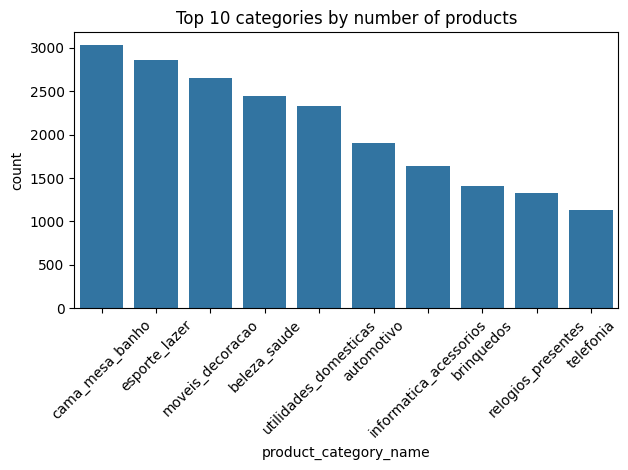

In [68]:
sns.barplot(x='product_category_name', y='count', data=df_products)
plt.title('Top 10 categories by number of products')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

In [ ]:
# Check missing values
# This SQL query checks the `products` table for missing values in two specific columns: `product_name_lenght` and `product_weight_g`. 
# It uses the `CASE WHEN ... THEN ... ELSE ... END` structure inside a `SUM()` function to count how many rows have NULL values in each column. 
# If a column value is NULL, it adds 1 to the total count; otherwise, it adds 0. 
# The result shows the total number of missing values in both columns, which is useful for assessing data completeness and potential data quality issues.
query = """
SELECT 
    SUM(CASE WHEN product_name_lenght IS NULL THEN 1 ELSE 0 END) AS missing_name_length,
    SUM(CASE WHEN product_weight_g IS NULL THEN 1 ELSE 0 END) AS missing_weight
FROM products;
"""
df_products = pd.read_sql(query, conn)
df_products

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3864329211.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_products = pd.read_sql(query, conn)


,missing_name_length,missing_weight
0,610,2


#### orders

In [63]:
# Count of orders by status
query = """
SELECT order_status, COUNT(*) AS count FROM orders GROUP BY order_status;
"""
df_orders = pd.read_sql(query, conn)
df_orders

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3708149495.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders = pd.read_sql(query, conn)


,order_status,count
0,shipped,1107
1,unavailable,609
2,invoiced,314
3,created,5
4,approved,2
5,processing,301
6,delivered,96478
7,canceled,625


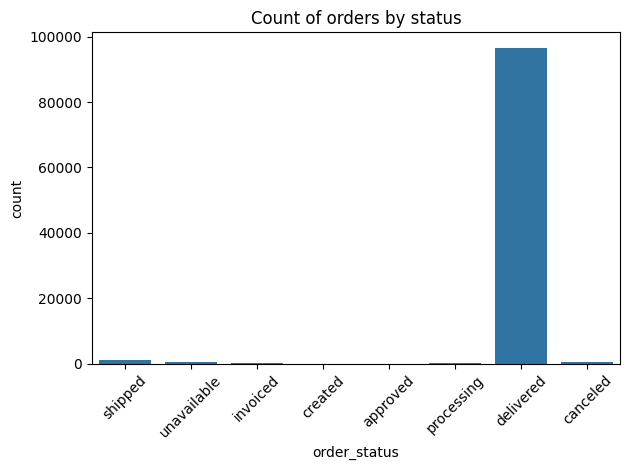

In [64]:
sns.barplot(x='order_status', y='count', data=df_orders)
plt.title('Count of orders by status')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

In [48]:
# Average delivery time (in days)
query = """
SELECT 
    ROUND(AVG(EXTRACT(DAY FROM order_delivered_customer_date - order_purchase_timestamp)), 2) AS avg_delivery_days
FROM orders
WHERE order_delivered_customer_date IS NOT NULL;
"""
df_orders = pd.read_sql(query, conn)
df_orders

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3717802554.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders = pd.read_sql(query, conn)


,avg_delivery_days
0,12.09


In [49]:
# Orders per month
query = """
SELECT 
    DATE_TRUNC('month', order_purchase_timestamp) AS month,
    COUNT(*) AS total_orders
FROM orders
GROUP BY month
ORDER BY month;
"""
df_orders = pd.read_sql(query, conn)
df_orders

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\699742522.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders = pd.read_sql(query, conn)


,month,total_orders
0,2016-09-01,4
1,2016-10-01,324
2,2016-12-01,1
3,2017-01-01,800
4,2017-02-01,1780
5,2017-03-01,2682
6,2017-04-01,2404
7,2017-05-01,3700
8,2017-06-01,3245
9,2017-07-01,4026


#### Customers

In [50]:
# Number of unique customers
query = """
SELECT COUNT(DISTINCT customer_id) AS total_customers FROM customers;
"""
df_customers = pd.read_sql(query, conn)
df_customers

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2719513496.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql(query, conn)


,total_customers
0,99441


In [69]:
# Top 10 cities by number of customers
query = """
SELECT customer_city, COUNT(*) AS count
FROM customers
GROUP BY customer_city
ORDER BY count DESC
LIMIT 10;
"""
df_customers = pd.read_sql(query, conn)
df_customers

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2604929618.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql(query, conn)


,customer_city,count
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


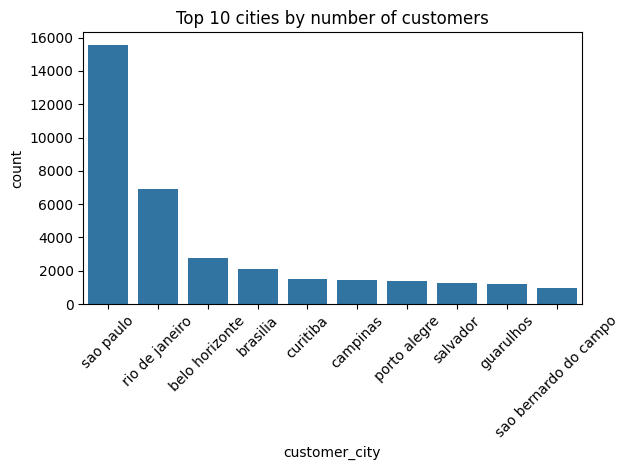

In [59]:
sns.barplot(x='customer_city', y='count', data=df_customers)
plt.title('Top 10 cities by number of customers')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()


In [60]:
# Count of customers per state
query = """
SELECT customer_state, COUNT(*) AS count
FROM customers
GROUP BY customer_state
ORDER BY count DESC
LIMIT 10;
"""
df_customers = pd.read_sql(query, conn)
df_customers

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3921069363.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql(query, conn)


,customer_state,count
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


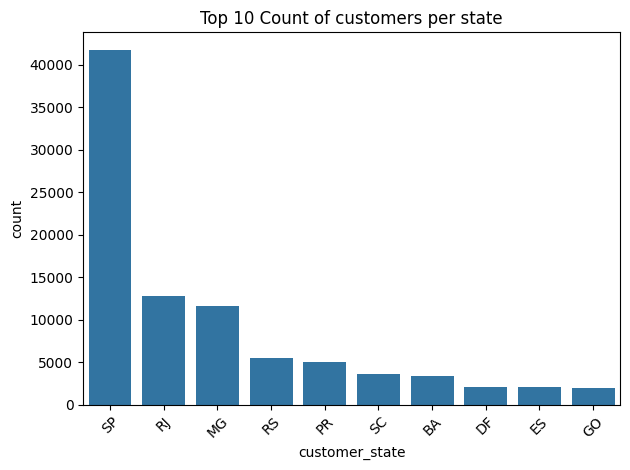

In [62]:
sns.barplot(x='customer_state', y='count', data=df_customers)
plt.title('Top 10 Count of customers per state')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

### Advanced Data Exploration Using SQL Joins and Visualizations

#### Internal join: average payments by product category

In [ ]:
query = """
SELECT 
    p.product_category_name,
    ROUND(AVG(oi.price), 2) AS avg_price,
    ROUND(AVG(py.payment_value), 2) AS avg_payment
FROM order_items oi
INNER JOIN products p ON oi.product_id = p.product_id
INNER JOIN payments py ON oi.order_id = py.order_id
GROUP BY p.product_category_name
ORDER BY avg_payment DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\113338286.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,product_category_name,avg_price,avg_payment
0,pcs,1098.34,1335.39
1,telefonia_fixa,225.69,781.96
2,portateis_casa_forno_e_cafe,624.29,667.13
3,agro_industria_e_comercio,342.12,546.47
4,eletrodomesticos_2,476.12,513.64
5,moveis_escritorio,162.01,378.38
6,sinalizacao_e_seguranca,108.09,343.96
7,construcao_ferramentas_seguranca,208.99,334.70
8,instrumentos_musicais,281.62,333.27
9,eletroportateis,280.78,323.32


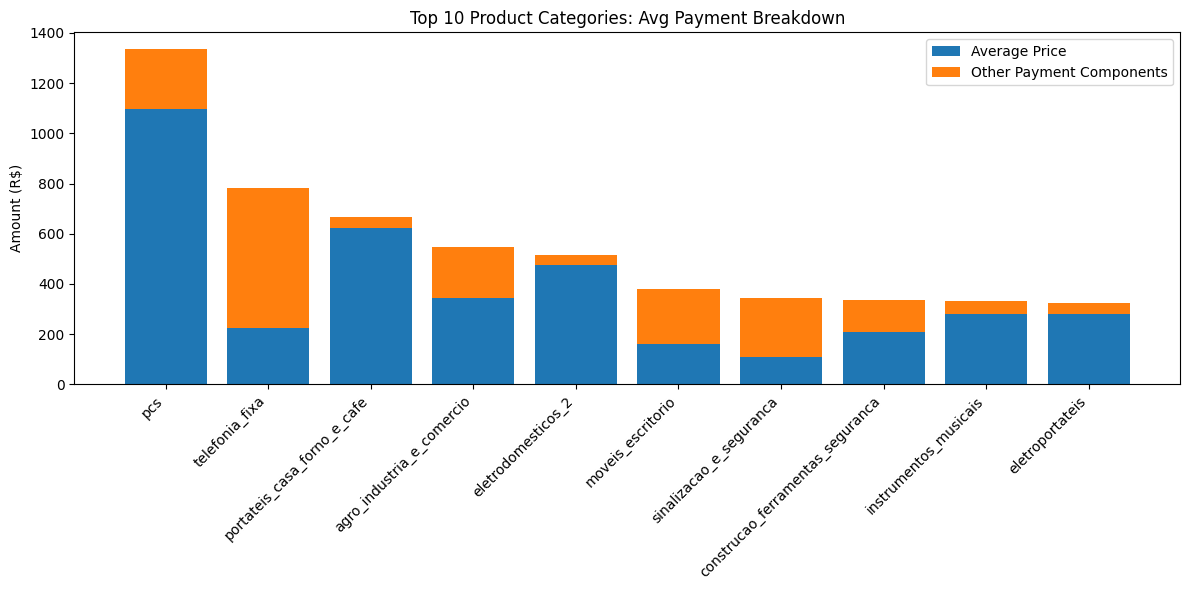

In [75]:
# Plot stacked bar chart
categories = df['product_category_name']
avg_price = df['avg_price']
avg_payment = df['avg_payment'] - df['avg_price'] # portion above price = extra cost (freight, etc.)

plt.figure(figsize=(12, 6))
plt.bar(categories, avg_price, label='Average Price')
plt.bar(categories, avg_payment, bottom=avg_price, label='Other Payment Components')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Amount (R$)')
plt.title('Top 10 Product Categories: Avg Payment Breakdown')
plt.legend()
plt.tight_layout()
plt.show()

<em>
The analysis of product categories shows significant variation between average price (`avg_price`) and average payment (`avg_payment`) across segments.

- **PCs** have the highest average price (1098.34) and the highest average payment (1335.39), indicating higher-value or premium products in this category.
- **Fixed telephony** and **portable kitchen and coffee appliances** show notable gaps between average price and payment, suggesting additional costs such as services, warranties, or shipping fees, or bulk purchases.
- Categories like **agro industry and commerce** and **home appliances** have moderate average prices but lower average payments, possibly due to discounts or promotions.
- Lower-priced categories (e.g., **office furniture**, **signage and security**) have relatively high average payments, which may reflect larger purchase volumes or complementary product purchases.

Overall, the difference between `avg_price` and `avg_payment` indicates that final payments include additional charges beyond the base product price, influencing the average amount spent per category.
</em>

#### External join: customers without orders (LEFT JOIN)

In [ ]:
query = """
SELECT 
    c.customer_id,
    c.customer_city,
    o.order_id
FROM customers c
LEFT JOIN orders o ON c.customer_id = o.customer_id
WHERE o.order_id IS NULL;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2770599468.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customer_id,customer_city,order_id


#### Orders by state and average score (INNER JOIN with reviews)

In [78]:
query = """
SELECT 
    c.customer_state,
    COUNT(o.order_id) AS total_orders,
    ROUND(AVG(r.review_score), 2) AS avg_score
FROM orders o
INNER JOIN customers c ON o.customer_id = c.customer_id
INNER JOIN reviews r ON o.order_id = r.order_id
GROUP BY c.customer_state
ORDER BY total_orders DESC;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2417416196.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customer_state,total_orders,avg_score
0,SP,41690,4.17
1,RJ,12765,3.87
2,MG,11625,4.14
3,RS,5483,4.13
4,PR,5038,4.18
5,SC,3623,4.07
6,BA,3357,3.86
7,DF,2148,4.06
8,GO,2024,4.04
9,ES,2016,4.04


C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\4111290167.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


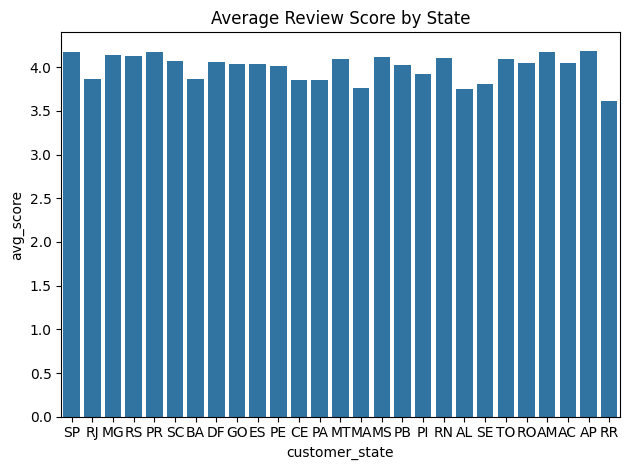

In [81]:
df = pd.read_sql_query(query, conn)
sns.barplot(x='customer_state', y='avg_score', data=df)
plt.title('Average Review Score by State')
plt.tight_layout()
plt.show()


<em>
This table shows the total number of orders and average customer satisfaction scores by state. São Paulo (SP) leads the way with 41,690 orders and a good average score of 4.17, indicating high volume and quality. Paraná (PR) and Amapá (AP) stand out with some of the highest satisfaction scores (4.18 and 4.19 respectively), despite lower order volumes, suggesting excellent customer experiences in these states. Conversely, states such as Rio de Janeiro (RJ) and Bahia (BA) show moderate scores, below 3.9, suggesting potential areas for service improvement. Roraima (RR) recorded the lowest satisfaction rate (3.61), highlighting a potential problem in this region. Overall, most high-frequency states maintained scores above 4, reflecting generally positive customer feedback nationwide.
</em>

#### Number of orders by state (customer_state)

In [ ]:
query = """
SELECT customer_state, COUNT(*) AS total_orders
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY customer_state
ORDER BY total_orders DESC;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\1216394517.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customer_state,total_orders
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


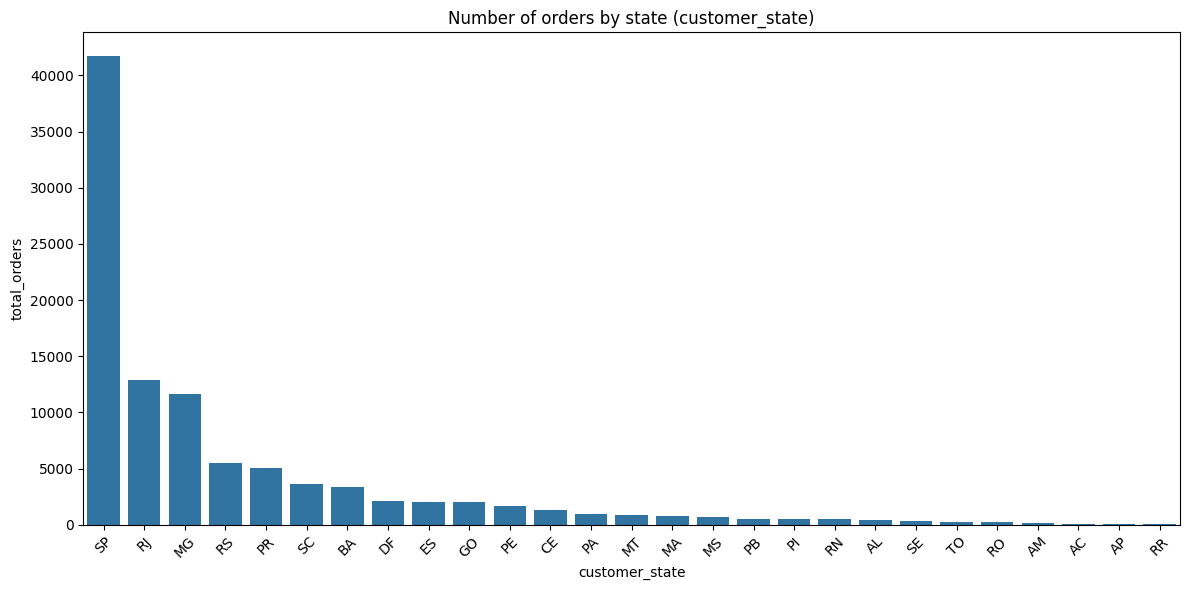

In [87]:
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', y='total_orders', data=df)
plt.title('Number of orders by state (customer_state)')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

<em>
This data set ranks Brazilian states according to the total number of orders placed. São Paulo (SP) dominates with 41,746 orders, well ahead of Rio de Janeiro (RJ) in second place with 12,852 orders. Minas Gerais (MG) follows close behind with 11,635 orders. Southern states such as Rio Grande do Sul (RS) and Paraná (PR) also posted high order volumes. By contrast, northern and less populous states such as Roraima (RR), Amapá (AP) and Acre (AC) recorded far fewer orders, reflecting regional disparities in terms of market size and customer base. This distribution highlights key markets and opportunities for targeted regional marketing and logistics planning.
</em>

#### Average payment by payment method

In [88]:
query = """
SELECT payment_type, ROUND(AVG(payment_value), 2) AS avg_payment
FROM payments
GROUP BY payment_type
ORDER BY avg_payment DESC;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\4170876233.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,payment_type,avg_payment
0,credit_card,164.73
1,boleto,145.03
2,debit_card,142.71
3,voucher,87.17
4,not_defined,0.00


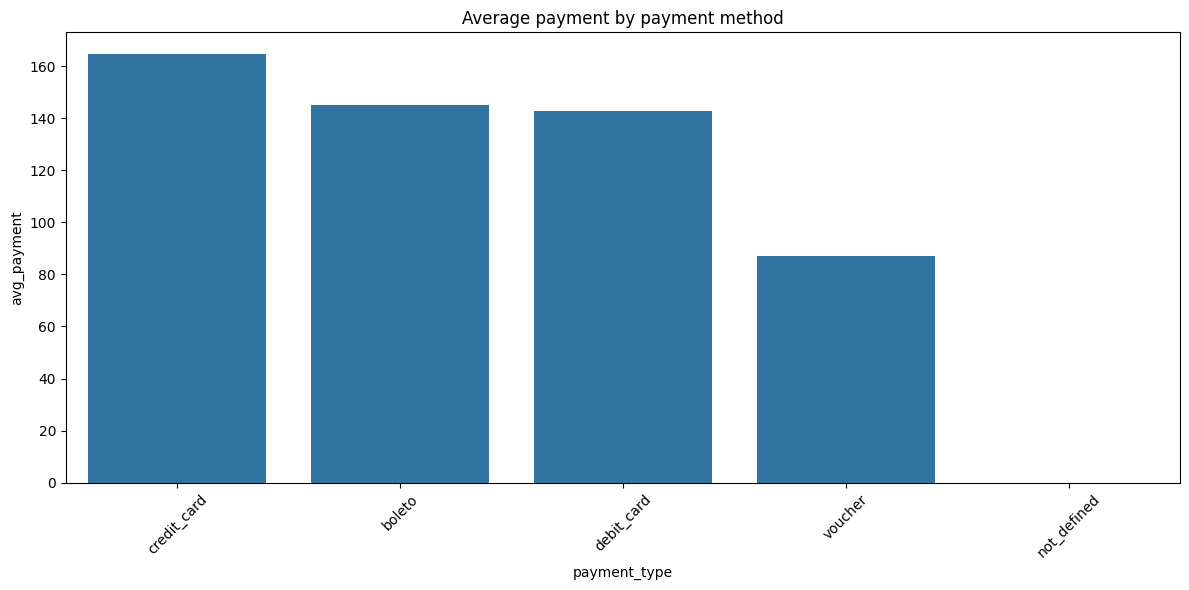

In [89]:
plt.figure(figsize=(12, 6))
sns.barplot(x='payment_type', y='avg_payment', data=df)
plt.title('Average payment by payment method')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

<em>
This table shows the average payment amount by payment type. Credit card payments lead with the highest average value (€164.73), followed by boleto (€145.03) and debit card (€142.71), indicating that these methods are preferred for larger transactions. Voucher payments have a lower average (€87.17), suggesting that they are used for smaller purchases. The “undefined” category has an average of zero, which probably represents missing or unclassified data. Understanding payment preferences enables payment options and marketing strategies to be adapted.
</em>

#### Top 10 product categories by sales volume

In [90]:
query = """
SELECT p.product_category_name, COUNT(*) AS total_items
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY total_items DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\4200613678.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,product_category_name,total_items
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


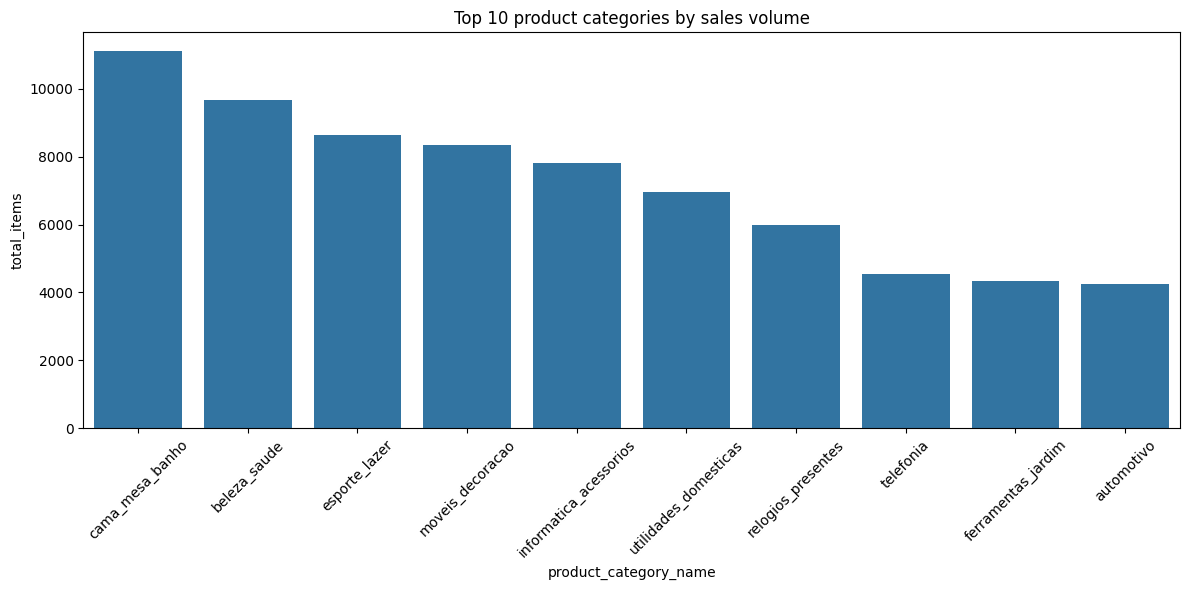

In [91]:
plt.figure(figsize=(12, 6))
sns.barplot(x='product_category_name', y='total_items', data=df)
plt.title('Top 10 product categories by sales volume')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

<em>
This data ranks product categories according to the total number of items sold. “Cama_mesa_banho” (bed, table, bath) tops the list with 11,115 items, indicating strong demand for home essentials. The “Beleza_saude” (beauty and health) and “esporte_lazer” (sports and leisure) categories follow close behind, reflecting consumer interest in personal care and leisure products. Categories such as “informatica_acessorios” (computer accessories) and “utilidades_domesticas” (household goods) also record strong sales, reflecting the diversity of consumer needs. This ranking enables us to establish inventory management and marketing priorities for the best-selling categories.
</em>

#### Average delivery time (in days) by state

In [92]:
query = """
SELECT c.customer_state,
       ROUND(AVG(EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 86400), 2) AS avg_delivery_days
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
WHERE order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state
ORDER BY avg_delivery_days;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2748858291.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customer_state,avg_delivery_days
0,SP,8.76
1,PR,11.99
2,MG,12.01
3,DF,12.97
4,SC,14.96
5,RS,15.30
6,RJ,15.31
7,GO,15.61
8,MS,15.62
9,ES,15.79


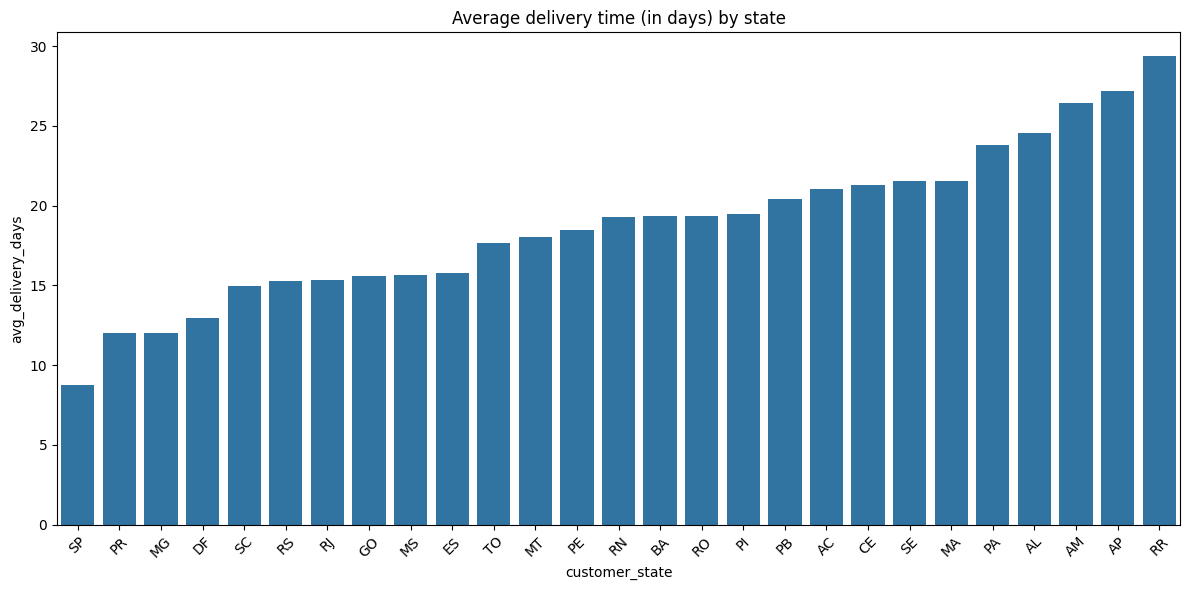

In [93]:
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', y='avg_delivery_days', data=df)
plt.title('Average delivery time (in days) by state')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

<em>
This table shows average delivery times by state, revealing clear regional disparities. São Paulo (SP) leads the way with the fastest deliveries (~8.76 days), reflecting a solid logistics infrastructure. In contrast, the northern states and some northeastern states such as Roraima (RR), Amapá (AP) and Amazonas (AM) have the longest delivery times, exceeding 26 days. This suggests problems linked to geographical distance, transport complexity or less developed supply chains in these regions. Understanding these differences is essential to targeting logistics improvements and managing customer expectations by state.
</em>

#### Average price, fees and payment by category

In [94]:
query = """
SELECT 
    p.product_category_name,
    ROUND(AVG(oi.price), 2) AS avg_price,
    ROUND(AVG(oi.freight_value), 2) AS avg_freight,
    ROUND(AVG(pay.payment_value), 2) AS avg_payment
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN payments pay ON oi.order_id = pay.order_id
GROUP BY p.product_category_name
ORDER BY avg_payment DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2920881313.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,product_category_name,avg_price,avg_freight,avg_payment
0,pcs,1098.34,48.45,1335.39
1,telefonia_fixa,225.69,17.57,781.96
2,portateis_casa_forno_e_cafe,624.29,36.16,667.13
3,agro_industria_e_comercio,342.12,27.56,546.47
4,eletrodomesticos_2,476.12,44.54,513.64
5,moveis_escritorio,162.01,40.55,378.38
6,sinalizacao_e_seguranca,108.09,32.70,343.96
7,construcao_ferramentas_seguranca,208.99,20.20,334.70
8,instrumentos_musicais,281.62,27.41,333.27
9,eletroportateis,280.78,23.59,323.32


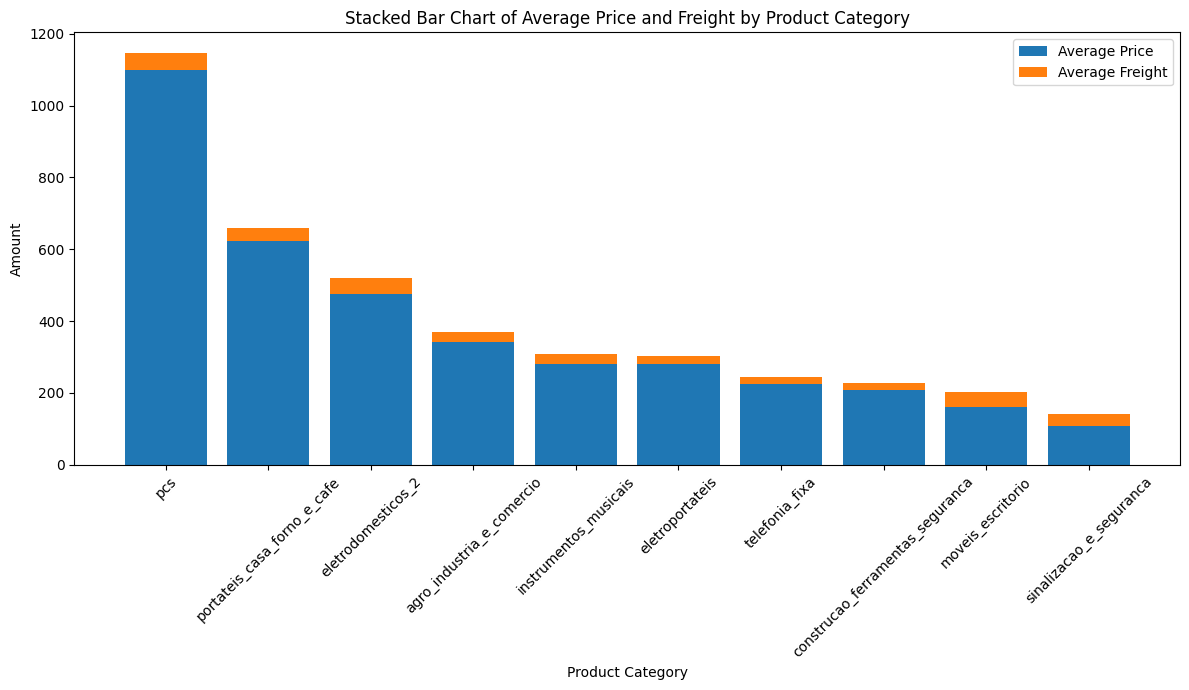

In [95]:
# Sort categories by avg_price + avg_freight for better visualization
df['total'] = df['avg_price'] + df['avg_freight']
df = df.sort_values('total', ascending=False).head(10)  # top 10 categories

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(df['product_category_name'], df['avg_price'], label='Average Price')
ax.bar(df['product_category_name'], df['avg_freight'], bottom=df['avg_price'], label='Average Freight')

ax.set_xlabel('Product Category')
ax.set_ylabel('Amount')
ax.set_title('Stacked Bar Chart of Average Price and Freight by Product Category')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<em>
This data compares average product price, freight cost, and total payment across categories. The "pcs" category stands out with the highest average price (1098.34) and payment (1335.39), indicating high-value products with relatively low freight costs (48.45). Other categories like "telefonia_fixa" and "portateis_casa_forno_e_cafe" show lower average prices but notably higher differences between average payment and price, suggesting significant additional costs (shipping, fees). Categories such as "moveis_escritorio" and "sinalizacao_e_seguranca" have lower prices but freight costs represent a large portion of total payment, highlighting the impact of logistics on overall spending. This insight helps identify which categories incur higher shipping overhead relative to product cost.
</em>

#### Monthly change in order volume

In [96]:
query = """
SELECT DATE_TRUNC('month', order_purchase_timestamp) AS month, COUNT(*) AS total_orders
FROM orders
GROUP BY month
ORDER BY month;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2990637568.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,month,total_orders
0,2016-09-01,4
1,2016-10-01,324
2,2016-12-01,1
3,2017-01-01,800
4,2017-02-01,1780
5,2017-03-01,2682
6,2017-04-01,2404
7,2017-05-01,3700
8,2017-06-01,3245
9,2017-07-01,4026


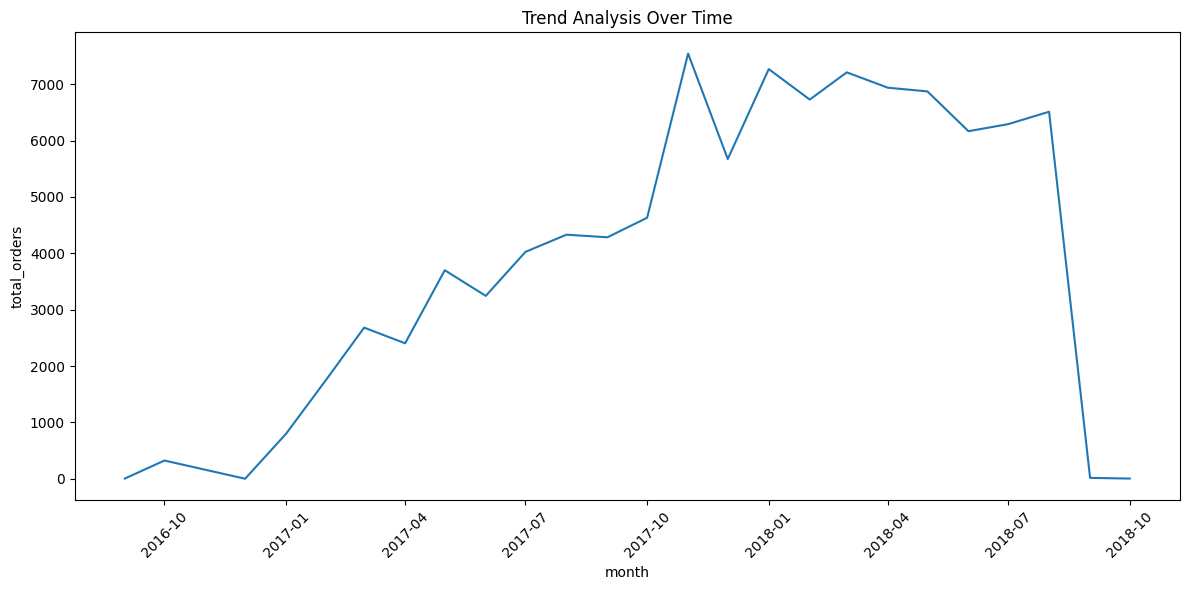

In [98]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='month', y='total_orders')
plt.title('Trend Analysis Over Time')
plt.xticks(rotation=45)  # si besoin de faire pivoter les dates
plt.tight_layout()
plt.show()

<em>
This monthly orders data highlights a clear upward trend in order volume from late 2016 through late 2017, peaking in November 2017 with 7,544 orders. After reaching this peak, order counts remain relatively high and stable through mid-2018, fluctuating between approximately 6,000 and 7,200 orders per month. The sharp drops in September and October 2018 to very low values likely indicate data gaps or anomalies rather than actual declines in activity. Overall, the trend reflects strong growth and sustained demand over the observed period.
</em>

#### Sellers with the most products sold

In [99]:
query = """
SELECT seller_id, COUNT(*) AS total_items_sold
FROM order_items
GROUP BY seller_id
ORDER BY total_items_sold DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\1748151397.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,seller_id,total_items_sold
0,6560211a19b47992c3666cc44a7e94c0,2033
1,4a3ca9315b744ce9f8e9374361493884,1987
2,1f50f920176fa81dab994f9023523100,1931
3,cc419e0650a3c5ba77189a1882b7556a,1775
4,da8622b14eb17ae2831f4ac5b9dab84a,1551
5,955fee9216a65b617aa5c0531780ce60,1499
6,1025f0e2d44d7041d6cf58b6550e0bfa,1428
7,7c67e1448b00f6e969d365cea6b010ab,1364
8,ea8482cd71df3c1969d7b9473ff13abc,1203
9,7a67c85e85bb2ce8582c35f2203ad736,1171


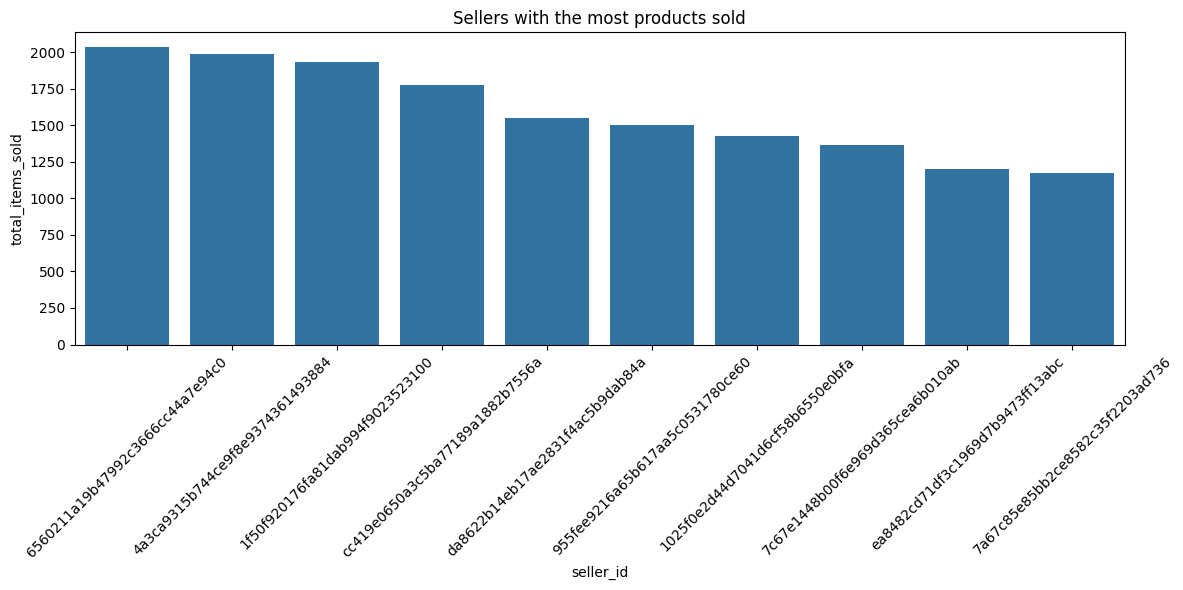

In [100]:
plt.figure(figsize=(12, 6))
sns.barplot(x='seller_id', y='total_items_sold', data=df)
plt.title('Sellers with the most products sold')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()       # Adjust layout to avoid label cutoff
plt.show()

<em>
This table shows the top 10 sellers based on the total number of items sold. The leading seller has sold 2,033 items, with a gradual decrease down the list to the tenth seller who sold 1,171 items. The relatively close sales volumes suggest a competitive marketplace where multiple sellers achieve high sales, indicating a healthy distribution of demand across sellers.
</em>

#### Délai moyen entre achat et livraison vs approbation

In [101]:
query = """
SELECT 
    ROUND(AVG(EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 86400), 2) AS avg_days_to_delivery,
    ROUND(AVG(EXTRACT(EPOCH FROM (order_approved_at - order_purchase_timestamp)) / 86400), 2) AS avg_days_to_approval
FROM orders
WHERE order_delivered_customer_date IS NOT NULL AND order_approved_at IS NOT NULL;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\1090008441.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,avg_days_to_delivery,avg_days_to_approval
0,12.56,0.43


#### Correlation between number of items and total amount paid

In [102]:
query = """
SELECT oi.order_id, COUNT(*) AS num_items, SUM(p.payment_value) AS total_payment
FROM order_items oi
JOIN payments p ON oi.order_id = p.order_id
GROUP BY oi.order_id
HAVING COUNT(*) < 20  -- to avoid outliers
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\2637778337.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,order_id,num_items,total_payment
0,00010242fe8c5a6d1ba2dd792cb16214,1,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,259.83
2,000229ec398224ef6ca0657da4fc703e,1,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,218.04
...,...,...,...
98657,fffc94f6ce00a00581880bf54a75a037,1,343.40
98658,fffcd46ef2263f404302a634eb57f7eb,1,386.53
98659,fffce4705a9662cd70adb13d4a31832d,1,116.85
98660,fffe18544ffabc95dfada21779c9644f,1,64.71


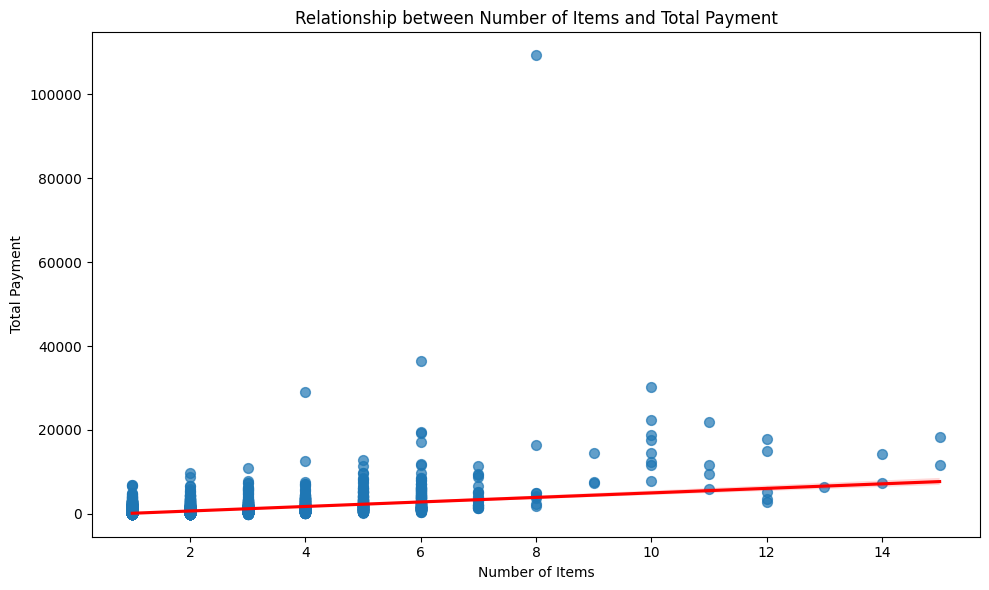

In [103]:
plt.figure(figsize=(10,6))
sns.regplot(x='num_items', y='total_payment', data=df, scatter_kws={'s':50, 'alpha':0.7}, line_kws={"color":"red"})
plt.title('Relationship between Number of Items and Total Payment')
plt.xlabel('Number of Items')
plt.ylabel('Total Payment')
plt.tight_layout()
plt.show()

#### Top customers by total payment amount (with subquery to calculate total)

In [104]:
query = """
SELECT customer_id, total_payment
FROM (
    SELECT customer_id, SUM(payment_value) AS total_payment
    FROM payments p
    JOIN orders o ON p.order_id = o.order_id
    GROUP BY customer_id
) AS customer_payments
ORDER BY total_payment DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\1454330962.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customer_id,total_payment
0,1617b1357756262bfa56ab541c47bc16,13664.08
1,ec5b2ba62e574342386871631fafd3fc,7274.88
2,c6e2731c5b391845f6800c97401a43a9,6929.31
3,f48d464a0baaea338cb25f816991ab1f,6922.21
4,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66
5,05455dfa7cd02f13d132aa7a6a9729c6,6081.54
6,df55c14d1476a9a3467f131269c2477f,4950.34
7,e0a2412720e9ea4f26c1ac985f6a7358,4809.44
8,24bbf5fd2f2e1b359ee7de94defc4a15,4764.34
9,3d979689f636322c62418b6346b1c6d2,4681.78


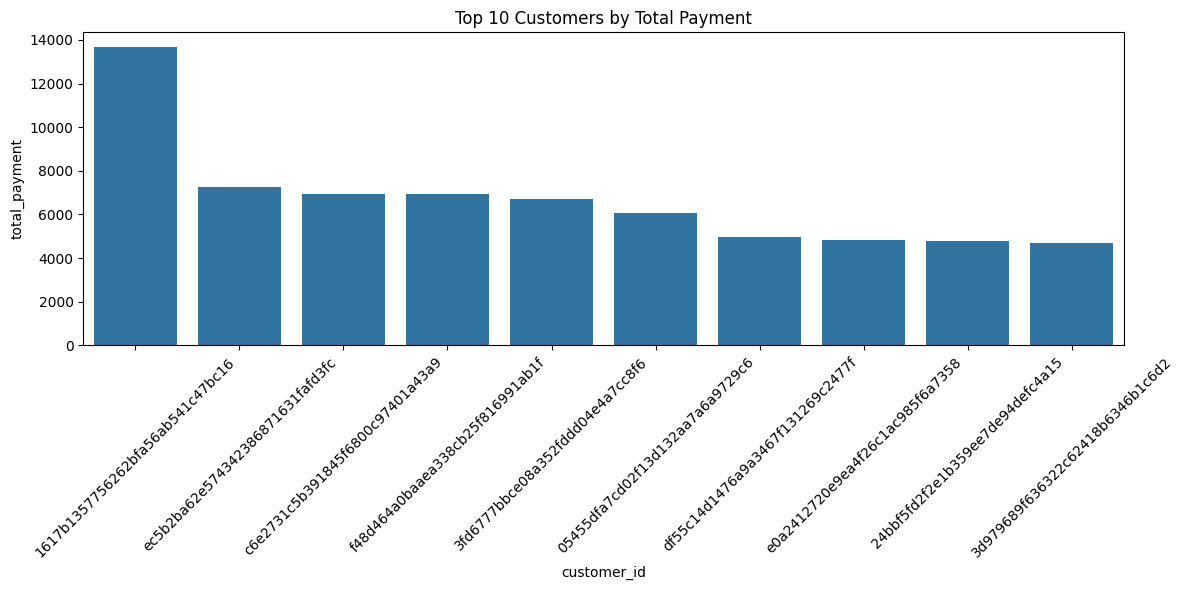

In [106]:
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_id', y='total_payment', data=df)
plt.title('Top 10 Customers by Total Payment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<em>This table highlights the top 10 customers ranked by their total payments. The highest spender paid over 13,600, which is nearly double the amount of the second highest. This indicates a significant variation in customer spending power, with a few customers contributing disproportionately to total revenue. Such insights can guide targeted marketing or loyalty programs focusing on high-value clients.</em>

#### Products with an average price above the general average (nested query with condition)

In [ ]:
query = """
SELECT product_category_name, AVG(price) AS avg_price
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY product_category_name
HAVING AVG(price) > (
    SELECT AVG(price) FROM order_items
);
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\3301524219.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,product_category_name,avg_price
0,climatizacao,185.269226
1,beleza_saude,130.163531
2,bebes,134.344173
3,musica,158.798684
4,consoles_games,138.491838
5,la_cuisine,146.785000
6,seguros_e_servicos,141.645000
7,eletroportateis,280.778468
8,construcao_ferramentas_iluminacao,135.131579
9,malas_acessorios,128.598883


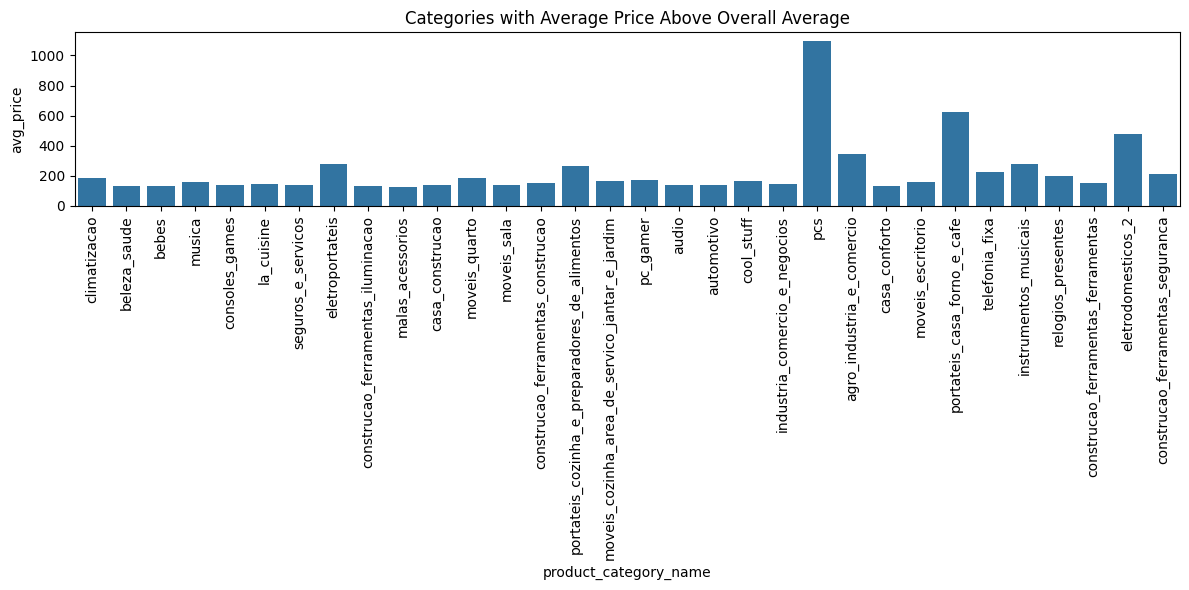

In [110]:
plt.figure(figsize=(12, 6))
sns.barplot(x='product_category_name', y='avg_price', data=df)
plt.xticks(rotation=90)
plt.title('Categories with Average Price Above Overall Average')
plt.tight_layout()
plt.show()

<em>

This analysis highlights the differences in average price (`avg_price`) across various product categories. Key insights include:

- 🔝 **The most expensive category** is **"pcs"** with an average price of **1098.34 BRL**, likely representing electronic products such as computers, justifying the high cost.
- 💸 **Other high-priced categories** include:
  - **"portateis_casa_forno_e_cafe"** (624.29 BRL)
  - **"eletrodomesticos_2"** (476.12 BRL)
  - **"instrumentos_musicais"** (281.61 BRL)
  - **"eletroportateis"** (280.78 BRL)  
  These categories consist of technical or household appliances, which tend to be more costly.

- 🧴 **The lower-priced categories** include:
  - **"malas_acessorios"** (128.59 BRL)
  - **"beleza_saude"** (130.16 BRL)
  - **"bebes"** (134.34 BRL)  
  These relate to everyday consumer goods or smaller items.

- 🧰 **Construction-related categories** (e.g., `construcao_ferramentas_*`) show moderate average prices (~135 to 155 BRL), reflecting product diversity within this segment.

- 🏠 **Furniture categories** (`moveis_*`) range between **137 and 183 BRL**, indicating relatively homogeneous pricing in home furnishing.

---

🎯 **Conclusion:**  
This comparison of average prices by category provides insights into product offering structure and vendor pricing strategies on the platform. Technical and IT products lead the most expensive categories, while accessories, beauty products, and baby items are among the least costly. These findings can guide profitability analyses and customer segmentation strategies.
</em>

#### Customers who have placed more than 5 orders and whose average score is above 4 (subquery for filtering)

In [111]:
query = """
SELECT customer_id, order_count, avg_review_score
FROM (
    SELECT o.customer_id, COUNT(o.order_id) AS order_count, AVG(r.review_score) AS avg_review_score
    FROM orders o
    LEFT JOIN reviews r ON o.order_id = r.order_id
    GROUP BY o.customer_id
) AS customer_stats
WHERE order_count > 5 AND avg_review_score > 4
ORDER BY avg_review_score DESC;
"""
df = pd.read_sql(query, conn)
df

C:\Users\alfa1\AppData\Local\Temp\ipykernel_6756\593499195.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customer_id,order_count,avg_review_score
